In [100]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from scipy import stats
import datetime

In [4]:
import cartopy.crs as ccrs   #import map styles/types
import cartopy.feature as cfeature  # features such as the ocean, coastlines rivers, etc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.ops import cascaded_union

In [5]:
#Importing Files
#37 and 39 refer to the location, 37 is Easter Island, and 39 is a nearby seamount called Pukao.
#The Hab files are the habitat analysis that I did, CTD contains the CTD data by timecode, and DT contains the latitude and longitude data by timecode.
Hab37 = pd.read_csv('37 - Habitat Analysis.csv')
Hab39 = pd.read_csv('39 - Habitat Analysis.csv')
CTD37 = pd.read_csv('37_CTD.csv')
CTD39 = pd.read_csv('39_CTD.csv')
DT37 = pd.read_csv('37_DT.csv')
DT39 = pd.read_csv('39_DT.csv')

2 research sites - 37 (SPG6, a seamount) and 39 (SPG7, Easter Island). The Hab37 and Hab39 dataframes contain the habitat analysis - substrate type, texture, bioturbation, etc. CTD37 and CTD39 are the dataframes with the CTD data, and DT37 and DT39 contain the latitude, longitude data and depth position of the deeptow camera unit at each point.

In [8]:
#Converting all of the files time and date columns to a single datetime object for each dataframe in the following lines.
Hab37['dte'] = Hab37['DATE'] + str(' ') + Hab37['TIME']

In [9]:
Hab37['dte'] = pd.to_datetime(Hab37['dte'], format='%m/%d/%Y %H:%M:%S')

In [10]:
#Me realizing a week later I should have set the datetimes as my indices.
Hab37 = Hab37.set_index(['dte'])

In [11]:
Hab39['dte'] = Hab39['DATE'] + str(' ') + Hab39['TIME']

In [12]:
Hab39['dte'] = pd.to_datetime(Hab39['dte'], format='%m/%d/%Y %H:%M:%S')

In [13]:
Hab39 = Hab39.set_index(['dte'])

In [14]:
CTD37['dte'] = CTD37['DATE'] + str(' ') + CTD37['TIME']

In [15]:
CTD37['dte'] = pd.to_datetime(CTD37['dte'], format='%m/%d/%Y %H:%M:%S')

In [16]:
CTD37 = CTD37.set_index(['dte'])

In [17]:
CTD39['dte'] = CTD39['DATE'] + str(' ') + CTD39['TIME']

In [18]:
CTD39['dte'] = pd.to_datetime(CTD39['dte'], format='%m/%d/%Y %H:%M:%S')

In [19]:
CTD39 = CTD39.set_index(['dte'])

In [20]:
DT37['dte'] = str('2/13/2019') + str(' ') + DT37['DATE']

In [21]:
DT37['dte'] = pd.to_datetime(DT37['dte'], format='%m/%d/%Y %H:%M:%S')

In [22]:
DT37 = DT37.set_index(['dte'])

In [23]:
DT39['dte'] = str('2/16/2019') + str(' ') + DT39['DATE']

In [24]:
DT39['dte'] = pd.to_datetime(DT39['dte'], format='%m/%d/%Y %H:%M:%S')

In [25]:
DT39 = DT39.set_index(['dte'])

In [26]:
#The latitude and longitude files are in degrees and minutes, so I converted them to degrees only. To do this I first split the data into two columns using the hyphen separating the degrees and minutes. This created a new dataframe 'split,' and I did this for both latitude and longitude.
split = DT37['Latitude'].str.split('-', n = 1, expand = True)
split_lon = DT37['Longitude'].str.split('-', n = 1, expand = True)

In [27]:
#Then used str.rstrip() to remove the remaining non-numerical characters from the string.
split[1] = split[1].str.rstrip(' ,S')
split_lon[1] = split_lon[1].str.rstrip(' ,W')

In [28]:
#And then converted the columns to integers and floats as needed for the calculations.
split[1] = split[1].astype(float)
split[1]

dte
2019-02-13 19:41:54     9.8848
2019-02-13 19:42:30     9.8871
2019-02-13 19:43:18    11.3013
2019-02-13 19:43:30    11.2994
2019-02-13 19:43:36    11.2989
                        ...   
2019-02-13 21:52:06    10.8641
2019-02-13 21:52:12    10.8634
2019-02-13 21:52:18    10.8642
2019-02-13 21:52:24    10.8628
2019-02-13 21:52:30    10.8616
Name: 1, Length: 1113, dtype: float64

In [29]:
split[0] = split[0].astype(int)
split[0]

dte
2019-02-13 19:41:54    26
2019-02-13 19:42:30    26
2019-02-13 19:43:18    26
2019-02-13 19:43:30    26
2019-02-13 19:43:36    26
                       ..
2019-02-13 21:52:06    26
2019-02-13 21:52:12    26
2019-02-13 21:52:18    26
2019-02-13 21:52:24    26
2019-02-13 21:52:30    26
Name: 0, Length: 1113, dtype: int32

In [30]:
#Calculating the latitude and adding it back to the original dataframe as a new column.
DT37['LAT'] = -1*((split[0])+((split[1])/60))

In [32]:
#And then dropping the NaN values.
DT37['LAT'].dropna()

dte
2019-02-13 19:41:54   -26.164747
2019-02-13 19:42:30   -26.164785
2019-02-13 19:43:18   -26.188355
2019-02-13 19:43:30   -26.188323
2019-02-13 19:43:36   -26.188315
                         ...    
2019-02-13 21:52:06   -26.181068
2019-02-13 21:52:12   -26.181057
2019-02-13 21:52:18   -26.181070
2019-02-13 21:52:24   -26.181047
2019-02-13 21:52:30   -26.181027
Name: LAT, Length: 1113, dtype: float64

In [33]:
#And nowdoing the same for longitude as well.
split_lon[1] = split_lon[1].astype(float)
split_lon[1]

dte
2019-02-13 19:41:54    58.7199
2019-02-13 19:42:30    58.5475
2019-02-13 19:43:18    59.8867
2019-02-13 19:43:30    59.8852
2019-02-13 19:43:36    59.8843
                        ...   
2019-02-13 21:52:06    58.5303
2019-02-13 21:52:12    58.5293
2019-02-13 21:52:18    58.5279
2019-02-13 21:52:24    58.5288
2019-02-13 21:52:30    58.5280
Name: 1, Length: 1113, dtype: float64

In [34]:
split_lon[0] = split_lon[0].astype(int)
split_lon[0]

dte
2019-02-13 19:41:54    102
2019-02-13 19:42:30    102
2019-02-13 19:43:18    102
2019-02-13 19:43:30    102
2019-02-13 19:43:36    102
                      ... 
2019-02-13 21:52:06    102
2019-02-13 21:52:12    102
2019-02-13 21:52:18    102
2019-02-13 21:52:24    102
2019-02-13 21:52:30    102
Name: 0, Length: 1113, dtype: int32

In [35]:
#Calculating the longitude and adding it back to the original dataframe as a new column.
DT37['LON'] = -1*((split_lon[0])+((split_lon[1])/60))

In [37]:
#Following the same steps again for DT39.
split = DT39['Latitude'].str.split('-', n = 1, expand = True)
split_lon = DT39['Longitude'].str.split('-', n = 1, expand = True)

In [38]:
split[1] = split[1].str.rstrip(' ,S')
split_lon[1] = split_lon[1].str.rstrip(' ,W')

In [39]:
split[1] = split[1].astype(float)
split[1]

dte
2019-02-16 19:36:42    4.0653
2019-02-16 19:39:12    4.0542
2019-02-16 19:39:24    4.0547
2019-02-16 19:39:30    4.0550
2019-02-16 19:39:36    4.0554
                        ...  
2019-02-16 22:45:42    3.8400
2019-02-16 22:45:48    3.8387
2019-02-16 22:45:54    3.8385
2019-02-16 22:46:00    3.8374
2019-02-16 22:46:06    3.8364
Name: 1, Length: 1635, dtype: float64

In [40]:
split[0] = split[0].astype(float)
split[0]

dte
2019-02-16 19:36:42    27.0
2019-02-16 19:39:12    27.0
2019-02-16 19:39:24    27.0
2019-02-16 19:39:30    27.0
2019-02-16 19:39:36    27.0
                       ... 
2019-02-16 22:45:42    27.0
2019-02-16 22:45:48    27.0
2019-02-16 22:45:54    27.0
2019-02-16 22:46:00    27.0
2019-02-16 22:46:06    27.0
Name: 0, Length: 1635, dtype: float64

In [41]:
DT39['LAT'] = -1*((split[0])+((split[1])/60))

In [42]:
DT39['LAT'] = DT39['LAT'].dropna()

In [44]:
split_lon[1] = split_lon[1].astype(float)
split_lon[1]

dte
2019-02-16 19:36:42    10.0314
2019-02-16 19:39:12    10.0274
2019-02-16 19:39:24    10.0279
2019-02-16 19:39:30    10.0272
2019-02-16 19:39:36    10.0254
                        ...   
2019-02-16 22:45:42    12.2095
2019-02-16 22:45:48    12.2114
2019-02-16 22:45:54    12.2126
2019-02-16 22:46:00    12.2135
2019-02-16 22:46:06    12.2158
Name: 1, Length: 1635, dtype: float64

In [45]:
split_lon[0] = split_lon[0].astype(float)
split_lon[0]

dte
2019-02-16 19:36:42    109.0
2019-02-16 19:39:12    109.0
2019-02-16 19:39:24    109.0
2019-02-16 19:39:30    109.0
2019-02-16 19:39:36    109.0
                       ...  
2019-02-16 22:45:42    109.0
2019-02-16 22:45:48    109.0
2019-02-16 22:45:54    109.0
2019-02-16 22:46:00    109.0
2019-02-16 22:46:06    109.0
Name: 0, Length: 1635, dtype: float64

In [46]:
#Calculating the longitude and adding it back to the original dataframe as a new column.
DT39['LON'] = -1*((split_lon[0])+((split_lon[1])/60))

In [47]:
#This is for indexing the DT files using the datetime index of the Hab files. It'll let me combine everything into one file.
#Starting with just getting the index time from the DT file

Hab_37 = []
num = 0
while num < 89:

    Hab37_2 = DT37.index[DT37.index.get_loc(Hab37.index[num], method='nearest')]
    Hab_37.append(Hab37_2)
    num = num +1
print(Hab_37)

[Timestamp('2019-02-13 20:10:42'), Timestamp('2019-02-13 20:11:18'), Timestamp('2019-02-13 20:12:18'), Timestamp('2019-02-13 20:13:18'), Timestamp('2019-02-13 20:14:18'), Timestamp('2019-02-13 20:15:18'), Timestamp('2019-02-13 20:16:18'), Timestamp('2019-02-13 20:17:18'), Timestamp('2019-02-13 20:18:18'), Timestamp('2019-02-13 20:19:18'), Timestamp('2019-02-13 20:20:18'), Timestamp('2019-02-13 20:21:18'), Timestamp('2019-02-13 20:22:12'), Timestamp('2019-02-13 20:23:18'), Timestamp('2019-02-13 20:24:18'), Timestamp('2019-02-13 20:25:24'), Timestamp('2019-02-13 20:26:18'), Timestamp('2019-02-13 20:27:18'), Timestamp('2019-02-13 20:28:18'), Timestamp('2019-02-13 20:29:18'), Timestamp('2019-02-13 20:30:18'), Timestamp('2019-02-13 20:31:12'), Timestamp('2019-02-13 20:32:18'), Timestamp('2019-02-13 20:33:18'), Timestamp('2019-02-13 20:34:12'), Timestamp('2019-02-13 20:35:18'), Timestamp('2019-02-13 20:36:18'), Timestamp('2019-02-13 20:37:18'), Timestamp('2019-02-13 20:38:18'), Timestamp('20

In [48]:
#Adding that time to the Hab37 dataframe

Hab37['LTIME'] = Hab_37

In [49]:
#Now getting the series with the latitude and longitude data, but they'll need some cleaning up.

Hab_37 = []
num = 0
while num < 89:

    Hab37_2 = DT37.iloc[DT37.index.get_loc(Hab37.index[num], method='nearest')][[11, 12]]
    Hab_37.append(Hab37_2)
    num = num +1
print(Hab_37)

[LAT   -26.1875
LON   -102.996
Name: 2019-02-13 20:10:42, dtype: object, LAT   -26.1875
LON   -102.996
Name: 2019-02-13 20:11:18, dtype: object, LAT   -26.1874
LON   -102.995
Name: 2019-02-13 20:12:18, dtype: object, LAT   -26.1873
LON   -102.995
Name: 2019-02-13 20:13:18, dtype: object, LAT   -26.1872
LON   -102.995
Name: 2019-02-13 20:14:18, dtype: object, LAT   -26.1871
LON   -102.995
Name: 2019-02-13 20:15:18, dtype: object, LAT   -26.1871
LON   -102.995
Name: 2019-02-13 20:16:18, dtype: object, LAT    -26.187
LON   -102.994
Name: 2019-02-13 20:17:18, dtype: object, LAT   -26.1868
LON   -102.994
Name: 2019-02-13 20:18:18, dtype: object, LAT   -26.1868
LON   -102.994
Name: 2019-02-13 20:19:18, dtype: object, LAT   -26.1867
LON   -102.994
Name: 2019-02-13 20:20:18, dtype: object, LAT   -26.1866
LON   -102.994
Name: 2019-02-13 20:21:18, dtype: object, LAT   -26.1865
LON   -102.993
Name: 2019-02-13 20:22:12, dtype: object, LAT   -26.1864
LON   -102.993
Name: 2019-02-13 20:23:18, dtype:

In [50]:
#I make a df column to work with, then make that a string to make it easier to work with
#Then split it, get rid of the extra index, and remove the letters and extra characters.
#Turn those into floats rather than strings, and then add them to the original df to the corresponding row.
##IT WORKS!!! Only took 2 weeks...... Now to do the same for Hab39 and then both CTD files.
num = 0
Hab37['LAT'] = ''
Hab37['LON'] = ''
    
while num <89:

    Hab37['LDATE'] = Hab_37
    st = str(Hab37['LDATE'][num])
    spl = st.split('\n')
    del(spl[2])
    spl = pd.DataFrame(spl)
    spl = spl[0].str.strip(' ,L,A,T,O,N')
    spl[0] = float(spl[0])
    spl[1] = float(spl[1])
    Hab37['LAT'][num] = spl[0]
    Hab37['LON'][num] = spl[1]
   
    num = num + 1
print(Hab37)

<ipython-input-50-1aabe08df4d1>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Hab37['LAT'][num] = spl[0]
<ipython-input-50-1aabe08df4d1>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Hab37['LON'][num] = spl[1]


                                                                 Image  \
dte                                                                      
2019-02-13 20:10:29  EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...   
2019-02-13 20:11:17  EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...   
2019-02-13 20:12:17  EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...   
2019-02-13 20:13:17  EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...   
2019-02-13 20:14:17  EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...   
...                                                                ...   
2019-02-13 21:39:18  EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...   
2019-02-13 21:40:18  EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...   
2019-02-13 21:41:18  EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...   
2019-02-13 21:42:18  EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...   
2019-02-13 21:43:18  EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...   

                          DATE      T

In [51]:
#Same thing, Hab39

Hab_39 = []
num = 0
while num < 150:

    Hab39_2 = DT39.index[DT39.index.get_loc(Hab39.index[num], method='nearest')]
    Hab_39.append(Hab39_2)
    num = num +1
print(Hab_39)

[Timestamp('2019-02-16 20:04:00'), Timestamp('2019-02-16 20:05:00'), Timestamp('2019-02-16 20:06:00'), Timestamp('2019-02-16 20:07:00'), Timestamp('2019-02-16 20:08:00'), Timestamp('2019-02-16 20:09:00'), Timestamp('2019-02-16 20:10:00'), Timestamp('2019-02-16 20:11:00'), Timestamp('2019-02-16 20:11:54'), Timestamp('2019-02-16 20:13:00'), Timestamp('2019-02-16 20:14:00'), Timestamp('2019-02-16 20:15:00'), Timestamp('2019-02-16 20:16:00'), Timestamp('2019-02-16 20:17:00'), Timestamp('2019-02-16 20:18:00'), Timestamp('2019-02-16 20:19:00'), Timestamp('2019-02-16 20:20:00'), Timestamp('2019-02-16 20:21:00'), Timestamp('2019-02-16 20:22:00'), Timestamp('2019-02-16 20:23:00'), Timestamp('2019-02-16 20:24:00'), Timestamp('2019-02-16 20:25:00'), Timestamp('2019-02-16 20:26:06'), Timestamp('2019-02-16 20:27:00'), Timestamp('2019-02-16 20:28:00'), Timestamp('2019-02-16 20:29:00'), Timestamp('2019-02-16 20:30:00'), Timestamp('2019-02-16 20:31:06'), Timestamp('2019-02-16 20:32:06'), Timestamp('20

In [52]:
#Adding that time to the Hab37 dataframe

Hab39['LTIME'] = Hab_39
Hab39

,Image,DATE,TIME,"Subsystem (Seamount vs island, seamount top, flank, base, island slope upper <200, intermediate500-1000, lower 1000+)",Class (meso-macrohab - based on seafloor morphology),"Substrate subclass (organic debris, mud, sand, gravel, pebble, cobble, boulder, mixed sediment, bedrock, sedimentary, Tapia: rock, silty sediments, mixed substrate, coarse sand)","Slope subclass(flat 0-5, sloping 5-30, steeply sloping 30-60, vertical 60-90, overhang >90)","M - morphology (regular: homogeneous, little relief; irregular: non-uniform, relief 1-10 m; hummocky: uniform bottom with mounds or depressions 0-3 m; outcrops)","M - deposition (dusting <1 cm, thin 1-5 cm, thick > 5 cm)","M - texture (sorting, packing, density: occasional, scattered, contiguous, pavement)",M - physical processes,M - chemical processes,"M - biological processes (bioturbation, % cover, communities)",M - anthropogenic processes,Altitude,CPC?,Unnamed: 16,LTIME
dte,,,,,,,,,,,,,,,,,,
2019-02-16 20:03:58,EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...,2/16/2019,20:03:58,Seamount SPG7a (Pukao),NaN,coarse sand,NaN,regular,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,2019-02-16 20:04:00
2019-02-16 20:04:58,EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...,2/16/2019,20:04:58,Seamount SPG7a (Pukao),NaN,coarse sand,NaN,regular,NaN,NaN,NaN,NaN,NaN,NaN,4.4,NaN,NaN,2019-02-16 20:05:00
2019-02-16 20:05:58,EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...,2/16/2019,20:05:58,Seamount SPG7a (Pukao),NaN,coarse sand,NaN,regular,NaN,NaN,NaN,NaN,NaN,NaN,4.9,NaN,NaN,2019-02-16 20:06:00
2019-02-16 20:06:58,EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...,2/16/2019,20:06:58,Seamount SPG7a (Pukao),NaN,coarse sand,NaN,regular,NaN,NaN,NaN,NaN,NaN,NaN,5.3,NaN,NaN,2019-02-16 20:07:00
2019-02-16 20:07:58,EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...,2/16/2019,20:07:58,Seamount SPG7a (Pukao),NaN,coarse sand,NaN,regular,NaN,NaN,NaN,NaN,NaN,NaN,5.6,NaN,NaN,2019-02-16 20:08:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-16 22:31:02,EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...,2/16/2019,22:31:02,Seamount SPG7a (Pukao),NaN,coarse sand,NaN,irregular,erosional features,NaN,NaN,NaN,coral?,NaN,4.5,?,NaN,2019-02-16 22:31:00
2019-02-16 22:32:02,EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...,2/16/2019,22:32:02,Seamount SPG7a (Pukao),NaN,coarse sand,NaN,irregular,erosional features,NaN,NaN,NaN,"coral?, rubble",NaN,3.2,?,NaN,2019-02-16 22:32:00
2019-02-16 22:33:02,EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...,2/16/2019,22:33:02,Seamount SPG7a (Pukao),NaN,coarse sand,NaN,irregular,erosional features,NaN,NaN,NaN,"coral?, crab, rubble",NaN,4.4,?,NaN,2019-02-16 22:33:00


In [53]:
Hab_39 = []
num = 0
while num < 150:

    Hab39_2 = DT39.iloc[DT39.index.get_loc(Hab39.index[num], method='nearest')][[0, 11, 12]]
    Hab_39.append(Hab39_2)
    num = num +1
print(Hab_39)

[DATE    20:04:00
LAT     -27.0671
LON     -109.169
Name: 2019-02-16 20:04:00, dtype: object, DATE    20:05:00
LAT     -27.0671
LON     -109.169
Name: 2019-02-16 20:05:00, dtype: object, DATE    20:06:00
LAT     -27.0675
LON     -109.169
Name: 2019-02-16 20:06:00, dtype: object, DATE    20:07:00
LAT     -27.0671
LON     -109.169
Name: 2019-02-16 20:07:00, dtype: object, DATE    20:08:00
LAT      -27.067
LON     -109.169
Name: 2019-02-16 20:08:00, dtype: object, DATE    20:09:00
LAT      -27.067
LON     -109.169
Name: 2019-02-16 20:09:00, dtype: object, DATE    20:10:00
LAT      -27.067
LON     -109.169
Name: 2019-02-16 20:10:00, dtype: object, DATE    20:11:00
LAT     -27.0669
LON      -109.17
Name: 2019-02-16 20:11:00, dtype: object, DATE    20:11:54
LAT     -27.0669
LON      -109.17
Name: 2019-02-16 20:11:54, dtype: object, DATE    20:13:00
LAT     -27.0668
LON      -109.17
Name: 2019-02-16 20:13:00, dtype: object, DATE    20:14:00
LAT     -27.0668
LON      -109.17
Name: 2019-02-16 2

In [54]:
#Only required a small modification, but now it's good. These loops are definitely getting easier, that's for sure.

num = 0
Hab39['LAT'] = ''
Hab39['LON'] = ''

    
while num <150:

    Hab39['LDATE'] = Hab_39
    st = str(Hab39['LDATE'][num])
    spl = st.split('\n')
    del(spl[-1], spl[0])
    spl = pd.DataFrame(spl)
    spl = spl[0].str.strip(' , L, A, T, O, N')
    spl[0] = float(spl[0])
    spl[1] = float(spl[1])
    Hab39['LAT'][num] = spl[0]
    Hab39['LON'][num] = spl[1]
   
    num = num + 1
print(Hab39)

<ipython-input-54-b80d7190bf83>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Hab39['LAT'][num] = spl[0]
<ipython-input-54-b80d7190bf83>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Hab39['LON'][num] = spl[1]


                                                                 Image  \
dte                                                                      
2019-02-16 20:03:58  EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...   
2019-02-16 20:04:58  EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...   
2019-02-16 20:05:58  EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...   
2019-02-16 20:06:58  EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...   
2019-02-16 20:07:58  EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...   
...                                                                ...   
2019-02-16 22:31:02  EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...   
2019-02-16 22:32:02  EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...   
2019-02-16 22:33:02  EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...   
2019-02-16 22:34:02  EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...   
2019-02-16 22:35:02  EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...   

                          DATE      T

In [55]:
#Had to add this bit for an issue with non-unique values - it just skips any additional non-unique values but keeps the first.
CTD37 = CTD37.loc[~CTD37.index.duplicated(keep = 'first')]

In [56]:
#Now to start on the CTD data

Hab_37 = []
num = 0
while num < 89:

    Hab37_2 = CTD37.index[CTD37.index.get_loc(Hab37.index[num], method='nearest')]
    Hab_37.append(Hab37_2)
    num = num +1
print(Hab_37)

[Timestamp('2019-02-13 20:10:29'), Timestamp('2019-02-13 20:11:17'), Timestamp('2019-02-13 20:12:17'), Timestamp('2019-02-13 20:13:17'), Timestamp('2019-02-13 20:14:17'), Timestamp('2019-02-13 20:15:17'), Timestamp('2019-02-13 20:16:17'), Timestamp('2019-02-13 20:17:17'), Timestamp('2019-02-13 20:18:17'), Timestamp('2019-02-13 20:19:17'), Timestamp('2019-02-13 20:20:17'), Timestamp('2019-02-13 20:21:17'), Timestamp('2019-02-13 20:22:17'), Timestamp('2019-02-13 20:23:17'), Timestamp('2019-02-13 20:24:17'), Timestamp('2019-02-13 20:25:17'), Timestamp('2019-02-13 20:26:17'), Timestamp('2019-02-13 20:27:17'), Timestamp('2019-02-13 20:28:17'), Timestamp('2019-02-13 20:29:17'), Timestamp('2019-02-13 20:30:17'), Timestamp('2019-02-13 20:31:17'), Timestamp('2019-02-13 20:32:18'), Timestamp('2019-02-13 20:33:18'), Timestamp('2019-02-13 20:34:18'), Timestamp('2019-02-13 20:35:18'), Timestamp('2019-02-13 20:36:18'), Timestamp('2019-02-13 20:37:18'), Timestamp('2019-02-13 20:38:18'), Timestamp('20

In [57]:
Hab37['CTIME'] = Hab_37
Hab37

,Image,DATE,TIME,"Subsystem (Seamount vs island, seamount top, flank, base, island slope upper <200, intermediate500-1000, lower 1000+)",Class (meso-macrohab - based on seafloor morphology),"Substrate subclass (organic debris, mud, sand, gravel, pebble, cobble, boulder, mixed sediment, bedrock, sedimentary, Tapia: rock, silty sediments, mixed substrate, coarse sand)","Slope subclass(flat 0-5, sloping 5-30, steeply sloping 30-60, vertical 60-90, overhang >90)","M - morphology (regular: homogeneous, little relief; irregular: non-uniform, relief 1-10 m; hummocky: uniform bottom with mounds or depressions 0-3 m; outcrops)","M - deposition (dusting <1 cm, thin 1-5 cm, thick > 5 cm)","M - texture (sorting, packing, density: occasional, scattered, contiguous, pavement)",...,CPC?,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,LTIME,LAT,LON,LDATE,CTIME
dte,,,,,,,,,,,,,,,,,,,,,
2019-02-13 20:10:29,EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...,2/13/2019,20:10:29,Seamount - EI (SPG7),Flat sandy bottom,coarse sand,NaN,regular,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2019-02-13 20:10:42,-26.1875,-102.996,LAT -26.1875 LON -102.996 Name: 2019-02-13...,2019-02-13 20:10:29
2019-02-13 20:11:17,EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...,2/13/2019,20:11:17,Seamount - EI (SPG7),NaN,coarse sand,NaN,regular,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2019-02-13 20:11:18,-26.1875,-102.996,LAT -26.1875 LON -102.996 Name: 2019-02-13...,2019-02-13 20:11:17
2019-02-13 20:12:17,EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...,2/13/2019,20:12:17,Seamount - EI (SPG7),NaN,coarse sand,NaN,regular,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2019-02-13 20:12:18,-26.1874,-102.995,LAT -26.1874 LON -102.995 Name: 2019-02-13...,2019-02-13 20:12:17
2019-02-13 20:13:17,EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...,2/13/2019,20:13:17,Seamount - EI (SPG7),NaN,rock,NaN,irregular with exposed volcanic bedrock,sediment - dusting,NaN,...,Y,NaN,NaN,NaN,NaN,2019-02-13 20:13:18,-26.1873,-102.995,LAT -26.1873 LON -102.995 Name: 2019-02-13...,2019-02-13 20:13:17
2019-02-13 20:14:17,EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...,2/13/2019,20:14:17,Seamount - EI (SPG7),NaN,rock,NaN,irregular with exposed volcanic bedrock,sediment - thin,NaN,...,Y,NaN,NaN,NaN,NaN,2019-02-13 20:14:18,-26.1872,-102.995,LAT -26.1872 LON -102.995 Name: 2019-02-13...,2019-02-13 20:14:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-13 21:39:18,EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...,2/13/2019,21:39:18,Seamount - EI (SPG7),NaN,coarse sand,NaN,regular,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2019-02-13 21:39:18,-26.1813,-102.976,LAT -26.1813 LON -102.976 Name: 2019-02-13...,2019-02-13 21:39:18
2019-02-13 21:40:18,EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...,2/13/2019,21:40:18,Seamount - EI (SPG7),NaN,coarse sand,NaN,regular,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2019-02-13 21:40:18,-26.1813,-102.976,LAT -26.1813 LON -102.976 Name: 2019-02-13...,2019-02-13 21:40:18
2019-02-13 21:41:18,EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...,2/13/2019,21:41:18,Seamount - EI (SPG7),NaN,coarse sand,NaN,regular,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2019-02-13 21:41:18,-26.1813,-102.976,LAT -26.1813 LON -102.976 Name: 2019-02-13...,2019-02-13 21:41:18


In [58]:
#Now getting the series with the latitude and longitude data, but they'll need some cleaning up.
#Same process as I used for the DT data, but just some modifications for the different data.

Hab_37 = []
num = 0
while num < 89:

    Hab37_2 = CTD37.iloc[CTD37.index.get_loc(Hab37.index[num], method='nearest')][[1, 3, 4, 5, 6]]
    Hab_37.append(Hab37_2)
    num = num +1
print(Hab_37)

[TIME         20:10:29
CTD_COND      3.28016
CTD_TEMP       4.4153
CTD_DEPTH      880.27
CTD_SAL       34.3888
Name: 2019-02-13 20:10:29, dtype: object, TIME         20:11:17
CTD_COND       3.2811
CTD_TEMP       4.4285
CTD_DEPTH      879.74
CTD_SAL       34.3865
Name: 2019-02-13 20:11:17, dtype: object, TIME         20:12:17
CTD_COND      3.28625
CTD_TEMP       4.5002
CTD_DEPTH       873.5
CTD_SAL       34.3756
Name: 2019-02-13 20:12:17, dtype: object, TIME         20:13:17
CTD_COND      3.29031
CTD_TEMP       4.5622
CTD_DEPTH      857.95
CTD_SAL       34.3667
Name: 2019-02-13 20:13:17, dtype: object, TIME         20:14:17
CTD_COND      3.29371
CTD_TEMP       4.6181
CTD_DEPTH      838.91
CTD_SAL       34.3583
Name: 2019-02-13 20:14:17, dtype: object, TIME         20:15:17
CTD_COND      3.29693
CTD_TEMP       4.6675
CTD_DEPTH      825.69
CTD_SAL       34.3514
Name: 2019-02-13 20:15:17, dtype: object, TIME         20:16:17
CTD_COND      3.29813
CTD_TEMP       4.6824
CTD_DEPTH      825.09

In [59]:
#Only required a small modification, but now it's good. These loops are definitely getting easier, that's for sure.

num = 0
Hab37['CTIME'] = ''
Hab37['COND'] = ''
Hab37['TEMP'] = ''
Hab37['DEPTH'] = ''
Hab37['SAL'] = ''

    
while num <89:

    Hab37['CDATE'] = Hab_37
    st = str(Hab37['CDATE'][num])
    spl = st.split('\n')
    del(spl[-1])
    spl = pd.DataFrame(spl)
    spl = spl[0].str.strip(' , T, I, M, E, C, D, P, H, S, A, L, O, N, _')
    spl[1] = float(spl[1])
    spl[2] = float(spl[2])
    spl[3] = float(spl[3])
    spl[4] = float(spl[4])
    Hab37['CTIME'][num] = spl[0]
    Hab37['COND'][num] = spl[1]
    Hab37['TEMP'][num] = spl[2]
    Hab37['DEPTH'][num] = spl[3]
    Hab37['SAL'][num] = spl[4]
   
    num = num + 1
print(Hab37)

<ipython-input-59-e0464dee080c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Hab37['CTIME'][num] = spl[0]
<ipython-input-59-e0464dee080c>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Hab37['COND'][num] = spl[1]
<ipython-input-59-e0464dee080c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Hab37['TEMP'][num] = spl[2]
<ipython-input-59-e0464dee080c>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

                                                                 Image  \
dte                                                                      
2019-02-13 20:10:29  EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...   
2019-02-13 20:11:17  EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...   
2019-02-13 20:12:17  EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...   
2019-02-13 20:13:17  EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...   
2019-02-13 20:14:17  EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...   
...                                                                ...   
2019-02-13 21:39:18  EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...   
2019-02-13 21:40:18  EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...   
2019-02-13 21:41:18  EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...   
2019-02-13 21:42:18  EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...   
2019-02-13 21:43:18  EPIC_Cruise_MR180603_6KCDT0037-20190213-194333...   

                          DATE      T

In [60]:
CTD39 = CTD39.loc[~CTD39.index.duplicated(keep = 'first')]

In [61]:
#Now to start on the CTD data

Hab_39 = []
num = 0
while num < 150:

    Hab39_2 = CTD39.index[CTD39.index.get_loc(Hab39.index[num], method='nearest')]
    Hab_39.append(Hab39_2)
    num = num +1
print(Hab_39)

[Timestamp('2019-02-16 20:03:58'), Timestamp('2019-02-16 20:04:58'), Timestamp('2019-02-16 20:05:58'), Timestamp('2019-02-16 20:06:58'), Timestamp('2019-02-16 20:07:58'), Timestamp('2019-02-16 20:08:58'), Timestamp('2019-02-16 20:09:58'), Timestamp('2019-02-16 20:10:58'), Timestamp('2019-02-16 20:11:58'), Timestamp('2019-02-16 20:12:58'), Timestamp('2019-02-16 20:13:58'), Timestamp('2019-02-16 20:14:58'), Timestamp('2019-02-16 20:15:58'), Timestamp('2019-02-16 20:16:59'), Timestamp('2019-02-16 20:17:59'), Timestamp('2019-02-16 20:18:59'), Timestamp('2019-02-16 20:19:59'), Timestamp('2019-02-16 20:20:59'), Timestamp('2019-02-16 20:21:59'), Timestamp('2019-02-16 20:22:59'), Timestamp('2019-02-16 20:23:59'), Timestamp('2019-02-16 20:24:59'), Timestamp('2019-02-16 20:25:59'), Timestamp('2019-02-16 20:26:59'), Timestamp('2019-02-16 20:27:59'), Timestamp('2019-02-16 20:28:59'), Timestamp('2019-02-16 20:29:59'), Timestamp('2019-02-16 20:30:59'), Timestamp('2019-02-16 20:31:59'), Timestamp('20

In [62]:
Hab39['CTIME'] = Hab_39

In [63]:
Hab_39 = []
num = 0
while num < 150:

    Hab39_2 = CTD39.iloc[CTD39.index.get_loc(Hab39.index[num], method='nearest')][[1, 3, 4, 5, 6]]
    Hab_39.append(Hab39_2)
    num = num +1
print(Hab_39)

[TIME         20:03:58
CTD_COND      3.25151
CTD_TEMP       3.9963
CTD_DEPTH     1058.04
CTD_SAL       34.3974
Name: 2019-02-16 20:03:58, dtype: object, TIME         20:04:58
CTD_COND      3.25159
CTD_TEMP       3.9968
CTD_DEPTH     1059.65
CTD_SAL        34.397
Name: 2019-02-16 20:04:58, dtype: object, TIME         20:05:58
CTD_COND      3.25191
CTD_TEMP       4.0021
CTD_DEPTH      1057.7
CTD_SAL       34.3964
Name: 2019-02-16 20:05:58, dtype: object, TIME         20:06:58
CTD_COND      3.25163
CTD_TEMP       3.9993
CTD_DEPTH     1056.36
CTD_SAL       34.3966
Name: 2019-02-16 20:06:58, dtype: object, TIME         20:07:58
CTD_COND      3.25216
CTD_TEMP       4.0059
CTD_DEPTH     1056.62
CTD_SAL       34.3959
Name: 2019-02-16 20:07:58, dtype: object, TIME         20:08:58
CTD_COND      3.25249
CTD_TEMP       4.0106
CTD_DEPTH     1056.57
CTD_SAL       34.3949
Name: 2019-02-16 20:08:58, dtype: object, TIME         20:09:58
CTD_COND      3.25229
CTD_TEMP       4.0075
CTD_DEPTH     1056.75

In [64]:
#Only required a small modification, but now it's good. These loops are definitely getting easier, that's for sure.

num = 0
Hab39['CTIME'] = ''
Hab39['COND'] = ''
Hab39['TEMP'] = ''
Hab39['DEPTH'] = ''
Hab39['SAL'] = ''

    
while num <150:

    Hab39['CDATE'] = Hab_39
    st = str(Hab39['CDATE'][num])
    spl = st.split('\n')
    del(spl[-1])
    spl = pd.DataFrame(spl)
    spl = spl[0].str.strip(' , T, I, M, E, C, D, P, H, S, A, L, O, N, _')
    spl[1] = float(spl[1])
    spl[2] = float(spl[2])
    spl[3] = float(spl[3])
    spl[4] = float(spl[4])
    Hab39['CTIME'][num] = spl[0]
    Hab39['COND'][num]=spl[1]
    Hab39['TEMP'][num] = spl[2]
    Hab39['DEPTH'][num] = spl[3]
    Hab39['SAL'][num] = spl[4]
   
    num = num + 1
print(Hab39)

<ipython-input-64-7569a7af91ab>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Hab39['CTIME'][num] = spl[0]
<ipython-input-64-7569a7af91ab>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Hab39['COND'][num]=spl[1]
<ipython-input-64-7569a7af91ab>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Hab39['TEMP'][num] = spl[2]
<ipython-input-64-7569a7af91ab>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

                                                                 Image  \
dte                                                                      
2019-02-16 20:03:58  EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...   
2019-02-16 20:04:58  EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...   
2019-02-16 20:05:58  EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...   
2019-02-16 20:06:58  EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...   
2019-02-16 20:07:58  EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...   
...                                                                ...   
2019-02-16 22:31:02  EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...   
2019-02-16 22:32:02  EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...   
2019-02-16 22:33:02  EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...   
2019-02-16 22:34:02  EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...   
2019-02-16 22:35:02  EPIC_Cruise_MR180603_6KCDT0039_6KCDT0039-20190...   

                          DATE      T

In [65]:
#Well that was painful and complicated but it's done and they're saved as .csv's so I can access them easily whenever.

Hab37.to_csv('HAB37.csv')

In [66]:
Hab39.to_csv('HAB39.csv')

In [68]:
#Sorted by depth in excel - I was having some issues plotting and this helped, though I'm not sure the order was the problem.

CTD37_sort = pd.read_csv('37_CTD_sort.csv')

In [69]:
CTD37_sort

,DATE,TIME,ALT,CTD_COND,CTD_TEMP,CTD_DEPTH,CTD_SAL,HEAD(GYRO),ROLL(GYRO),PITCH(GYRO)
0,2/13/2019,19:46:31,---.-,5.44878,24.8273,8.76,36.1893,25.6,0.3,6.8
1,2/13/2019,19:46:30,---.-,5.44882,24.8279,9.03,36.1891,28.7,0.0,4.1
2,2/13/2019,19:46:32,---.-,5.44871,24.8267,9.11,36.1892,25.6,0.3,6.8
3,2/13/2019,19:46:29,---.-,5.44892,24.8288,9.75,36.1889,28.6,0.2,3.9
4,2/13/2019,19:46:33,---.-,5.44854,24.8245,9.87,36.1895,23.3,-0.6,12.1
...,...,...,...,...,...,...,...,...,...,...
7809,2/13/2019,20:10:38,5.1394,3.28016,4.4151,880.93,34.3887,126.3,-1.8,2.5
7810,2/13/2019,20:10:37,5.0518,3.28016,4.4151,881.02,34.3887,127.0,-2.1,2.2
7811,2/13/2019,20:10:36,NaN,3.28009,4.4141,881.04,34.3889,127.3,-2.1,2.6
7812,2/13/2019,20:10:52,4.1504,3.28018,4.4155,881.14,34.3885,118.3,-1.8,3.1


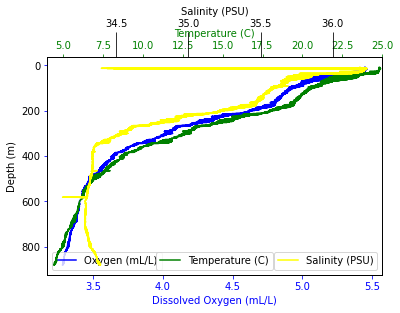

In [70]:
#Plotting profiles of dissolved oxygen, temp, and salinity by depth.
#First for site 37.

fig, ax = plt.subplots()
ax.plot(CTD37_sort['CTD_COND'], CTD37_sort['CTD_DEPTH'], color = 'blue', label = 'Oxygen (mL/L)')
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Dissolved Oxygen (mL/L)', color = 'blue')
ax.tick_params(color = 'blue')
ax.set_xticklabels(ax.get_xticks(), color = 'blue')
ax2 = ax.twiny()
ax2.plot(CTD37_sort['CTD_TEMP'], CTD37_sort['CTD_DEPTH'], color = 'green', label = 'Temperature (C)')
ax2.set_xlabel('Temperature (C)', color = 'green')
ax2.set_xlim(4, 25)
ax2.tick_params(color = 'green')
ax2.set_xticklabels(ax2.get_xticks(), color = 'green')
ax3 = ax.twiny()
ax3.plot(CTD37_sort['CTD_SAL'], CTD37_sort['CTD_DEPTH'], color = 'yellow', label = 'Salinity (PSU)')
ax3.set_xlabel('Salinity (PSU)')
ax3.tick_params(length = 25)
ax3.set_xticklabels(ax3.get_xticks())
ax2.yaxis.set_visible(False)
ax3.yaxis.set_visible(False)
plt.gca().invert_yaxis()
ax.legend(loc = 3)
ax2.legend(loc = 8)
ax3.legend(loc = 4)
fig.savefig('37 CTD Profile.png')

In [71]:
CTD39_sort = pd.read_csv('39_CTD_sort.csv')

In [72]:
CTD39_sort

,DATE,TIME,ALT,CTD_COND,CTD_TEMP,CTD_DEPTH,CTD_SAL,HEAD(GYRO),ROLL(GYRO),PITCH(GYRO)
0,2/16/2019,19:42:03,---.-,5.51024,25.5705,12.44,36.0515,184.6,-0.8,3.2
1,2/16/2019,19:39:21,---.-,4.92151,25.5462,12.68,31.7697,215.5,-5.0,2.3
2,2/16/2019,19:42:02,---.-,5.51027,25.5708,12.76,36.0513,185.4,-0.5,1.4
3,2/16/2019,19:39:36,329.3304,4.92015,25.5476,12.79,31.7589,209.3,-2.7,2.1
4,2/16/2019,19:41:00,NaN,5.50816,25.5524,12.84,36.0503,197.4,-1.1,1.8
...,...,...,...,...,...,...,...,...,...,...
11202,2/16/2019,20:04:07,4.9016,3.25171,3.9976,1060.88,34.3970,209.2,0.3,1.6
11203,2/16/2019,20:04:28,NaN,3.25188,3.9994,1060.88,34.3972,213.8,0.2,-0.9
11204,2/16/2019,20:04:19,4.3006,3.25173,3.9975,1060.89,34.3973,215.0,0.3,2.7
11205,2/16/2019,20:04:21,4.3382,3.25175,3.9977,1061.09,34.3972,215.0,0.4,1.3


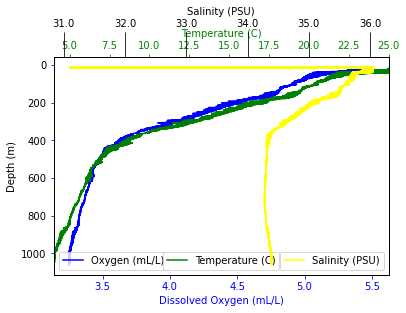

In [73]:
#Same thing for site 39

fig, ax = plt.subplots()
ax.plot(CTD39_sort['CTD_COND'], CTD39_sort['CTD_DEPTH'], color = 'blue', label = 'Oxygen (mL/L)')
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Dissolved Oxygen (mL/L)', color = 'blue')
ax.tick_params(color = 'blue')
ax.set_xticklabels(ax.get_xticks(), color = 'blue')
ax2 = ax.twiny()
ax2.plot(CTD39_sort['CTD_TEMP'], CTD39_sort['CTD_DEPTH'], color = 'green', label = 'Temperature (C)')
ax2.set_xlabel('Temperature (C)', color = 'green')
ax2.set_xlim(4, 25)
ax2.tick_params(color = 'green')
ax2.set_xticklabels(ax2.get_xticks(), color = 'green')
ax3 = ax.twiny()
ax3.plot(CTD39_sort['CTD_SAL'], CTD39_sort['CTD_DEPTH'], color = 'yellow', label = 'Salinity (PSU)')
ax3.set_xlabel('Salinity (PSU)')
ax3.tick_params(length = 25)
ax3.set_xticklabels(ax3.get_xticks())
ax2.yaxis.set_visible(False)
ax3.yaxis.set_visible(False)
plt.gca().invert_yaxis()
ax.legend(loc = 3)
ax2.legend(loc = 8)
ax3.legend(loc = 4)
fig.savefig('39 CTD Profile.png')

C:\Users\Kara\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\Kara\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


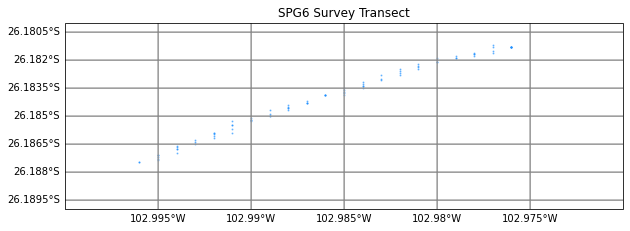

In [75]:
#Mapping the survey transects by image lat and long. Starting with 37.

fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.set_extent([-103, -102.97, -26.18, -26.19])

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.gridlines()

plt.scatter(x=Hab37['LON'], y=Hab37['LAT'],
            color="dodgerblue",
            s=1,
            alpha=0.5,
            transform=ccrs.PlateCarree()) ## Important

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5)
gl.xlabels_top = False
gl.ylabels_right = False

plt.title('SPG6 Survey Transect')

fig.savefig('SPG6 Transect.png')

plt.show()

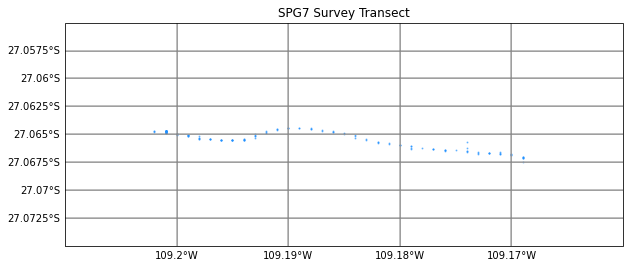

In [76]:
#And again for Easter island site

fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.set_extent([-109.21, -109.16, -27.055, -27.075])

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.gridlines()

plt.scatter(x=Hab39['LON'], y=Hab39['LAT'],
            color="dodgerblue",
            s=1,
            alpha=0.5,
            transform=ccrs.PlateCarree()) ## Important

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5)
gl.xlabels_top = False
gl.ylabels_right = False

plt.title('SPG7 Survey Transect')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

fig.savefig('SPG7 Transect.png')

plt.show()

In [77]:
#Opening up a NetCDF file for dissolved oxygen. This was data I got online from CSIRO, it's CARS 2009.
file = 'C:/Users/Kara/Documents/UTRGV/Year 1/Spring/MARS 5170/oxygen_cars2009.nc'

In [78]:
oxygen = xr.open_dataset(file, decode_times=False)

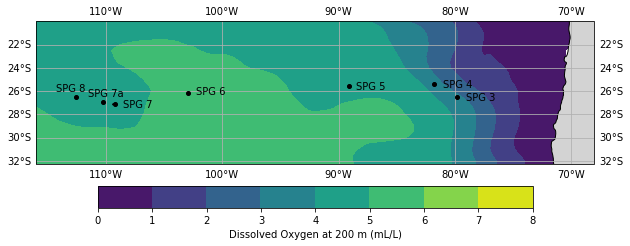

In [79]:
#Mapping dissolved oxygen - colorbar to show the range of values. 4 maps at intervals of 200 m.
#I'll do four plots, at increments of 200 meters.

fig, ax = plt.subplots(figsize =(10,8))  
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-116, -68, -20, -30])
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='black',
                                    facecolor='lightgrey')
ax.add_feature(land_50m)
ax.gridlines(draw_labels=True)
plt.plot(-79.808, -26.4751, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-81.7699, -25.4037, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-89.1258, -25.5935, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-102.976, -26.1813, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-109.202, -27.0647, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-110.239, -26.9653, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-112.625, -26.4902, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.text(-76.5, -26.75, 'SPG 3', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-78.5, -25.7, 'SPG 4', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-86, -25.85, 'SPG 5', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-99.75, -26.3, 'SPG 6', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-106, -27.35, 'SPG 7', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-108.45, -26.45, 'SPG 7a', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-111.75, -26, 'SPG 8', horizontalalignment='right', transform=ccrs.PlateCarree())

#Time is in hours, so this is 3 days later.
x = oxygen.lon
y = oxygen.lat
z = oxygen['mean'][24]

#Contours
cf = ax.contourf(x, y, z, transform=ccrs.PlateCarree()) # projection is needed in every plot call
cbar = plt.colorbar(cf, orientation = 'horizontal', pad=0.05, fraction=0.05)
cbar.set_label("Dissolved Oxygen at 200 m (mL/L)")
fig.savefig('OMZ 200 m.png')

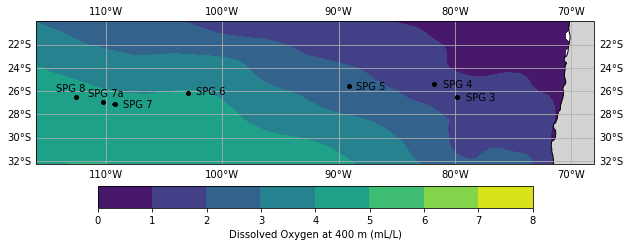

In [80]:
fig, ax = plt.subplots(figsize =(10,8))  
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-116, -68, -20, -30])
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='black',
                                    facecolor='lightgrey')
ax.add_feature(land_50m)
ax.gridlines(draw_labels=True)
plt.plot(-79.808, -26.4751, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-81.7699, -25.4037, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-89.1258, -25.5935, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-102.976, -26.1813, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-109.202, -27.0647, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-110.239, -26.9653, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-112.625, -26.4902, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.text(-76.5, -26.75, 'SPG 3', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-78.5, -25.7, 'SPG 4', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-86, -25.85, 'SPG 5', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-99.75, -26.3, 'SPG 6', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-106, -27.35, 'SPG 7', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-108.45, -26.45, 'SPG 7a', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-111.75, -26, 'SPG 8', horizontalalignment='right', transform=ccrs.PlateCarree())

#Time is in hours, so this is 3 days later.
x = oxygen.lon
y = oxygen.lat
z = oxygen['mean'][40]

#Contours
cf = ax.contourf(x, y, z, transform=ccrs.PlateCarree()) # projection is needed in every plot call
cbar = plt.colorbar(cf, orientation = 'horizontal', pad=0.05, fraction=0.05)
cbar.set_label("Dissolved Oxygen at 400 m (mL/L)")
fig.savefig('OMZ 400 m.png')

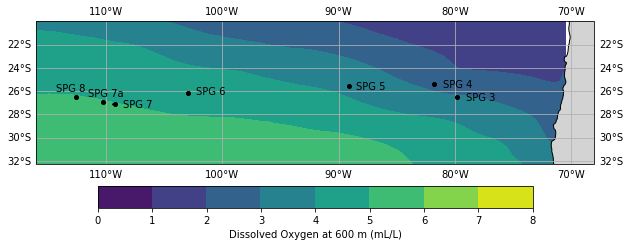

In [81]:
fig, ax = plt.subplots(figsize =(10,8))  
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-116, -68, -20, -30])
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='black',
                                    facecolor='lightgrey')
ax.add_feature(land_50m)
ax.gridlines(draw_labels=True)
plt.plot(-79.808, -26.4751, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-81.7699, -25.4037, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-89.1258, -25.5935, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-102.976, -26.1813, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-109.202, -27.0647, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-110.239, -26.9653, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-112.625, -26.4902, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.text(-76.5, -26.75, 'SPG 3', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-78.5, -25.7, 'SPG 4', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-86, -25.85, 'SPG 5', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-99.75, -26.3, 'SPG 6', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-106, -27.35, 'SPG 7', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-108.45, -26.45, 'SPG 7a', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-111.75, -26, 'SPG 8', horizontalalignment='right', transform=ccrs.PlateCarree())

#Time is in hours, so this is 3 days later.
x = oxygen.lon
y = oxygen.lat
z = oxygen['mean'][46]

#Contours
cf = ax.contourf(x, y, z, transform=ccrs.PlateCarree()) # projection is needed in every plot call
cbar = plt.colorbar(cf, orientation = 'horizontal', pad=0.05, fraction=0.05)
cbar.set_label("Dissolved Oxygen at 600 m (mL/L)")
fig.savefig('OMZ 600 m.png')

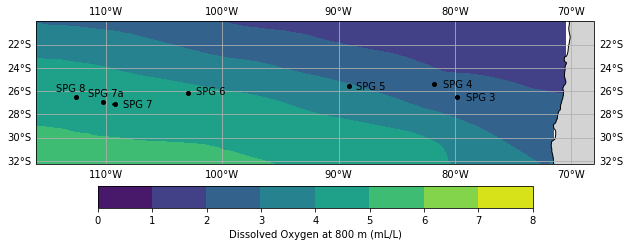

In [82]:
fig, ax = plt.subplots(figsize =(10,8))  
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-116, -68, -20, -30])
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='black',
                                    facecolor='lightgrey')
ax.add_feature(land_50m)
ax.gridlines(draw_labels=True)
plt.plot(-79.808, -26.4751, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-81.7699, -25.4037, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-89.1258, -25.5935, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-102.976, -26.1813, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-109.202, -27.0647, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-110.239, -26.9653, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.plot(-112.625, -26.4902, color = 'black', markersize=4, marker='o', transform = ccrs.PlateCarree())
plt.text(-76.5, -26.75, 'SPG 3', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-78.5, -25.7, 'SPG 4', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-86, -25.85, 'SPG 5', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-99.75, -26.3, 'SPG 6', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-106, -27.35, 'SPG 7', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-108.45, -26.45, 'SPG 7a', horizontalalignment='right', transform=ccrs.PlateCarree())
plt.text(-111.75, -26, 'SPG 8', horizontalalignment='right', transform=ccrs.PlateCarree())

#Time is in hours, so this is 3 days later.
x = oxygen.lon
y = oxygen.lat
z = oxygen['mean'][50]

#Contours
cf = ax.contourf(x, y, z, transform=ccrs.PlateCarree()) # projection is needed in every plot call
cbar = plt.colorbar(cf, orientation = 'horizontal', pad=0.05, fraction=0.05)
cbar.set_label("Dissolved Oxygen at 800 m (mL/L)")
fig.savefig('OMZ 800 m.png')

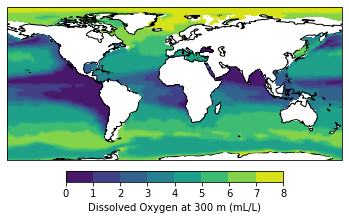

In [83]:
#Just for funsies - dissolved O2, 300 m around the world.

fig, ax = plt.subplots()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='110m')
x = oxygen.lon
y = oxygen.lat
z = oxygen['mean'][36]

ax.contour(x, y, z)

cf = ax.contourf(x, y, z, transform=ccrs.PlateCarree()) # projection is needed in every plot call
cbar = plt.colorbar(cf, orientation = 'horizontal', pad=0.05, fraction=0.05)
cbar.set_label("Dissolved Oxygen at 300 m (mL/L)")
fig.savefig('OMZ 300 m World.png')

Text(0, 0.5, 'Dissolved Oxygen (mL/L)')

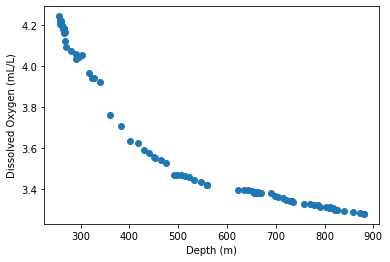

In [84]:
#Setting up for my linear regression for depth and dissolved oxygen.
#First for 37

plt.scatter(Hab37['DEPTH'], Hab37['COND'])
plt.xlabel('Depth (m)')
plt.ylabel('Dissolved Oxygen (mL/L)')

In [85]:
slope, intercept, r_value, p_value, std_err = stats.linregress(Hab37['DEPTH'].astype(float), Hab37['COND'].astype(float))

In [86]:
slope

-0.0015069672308957514

In [87]:
intercept

4.446118604975034

In [88]:
r_value

-0.9310114062482807

In [89]:
p_value

7.580247134537723e-40

In [90]:
std_err

6.333886056806438e-05

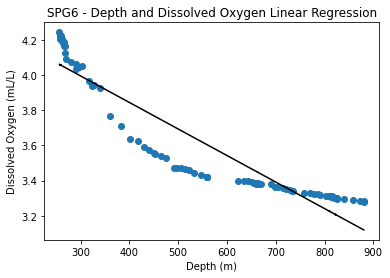

In [91]:
#Plotting the model
fig, ax = plt.subplots()
ax.scatter(Hab37['DEPTH'], Hab37['COND'])
ax.plot(Hab37['DEPTH'], slope*Hab37['DEPTH']+intercept, color = 'black')
ax.set_xlabel('Depth (m)')
ax.set_ylabel('Dissolved Oxygen (mL/L)')
ax.set_title('SPG6 - Depth and Dissolved Oxygen Linear Regression')
fig.savefig('SPG6 Regression.png')

Text(0, 0.5, 'Dissolved Oxygen (mL/L)')

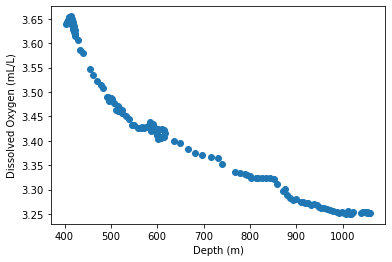

In [92]:
#And same again for 39

plt.scatter(Hab39['DEPTH'], Hab39['COND'])
plt.xlabel('Depth (m)')
plt.ylabel('Dissolved Oxygen (mL/L)')

In [93]:
slope, intercept, r_value, p_value, std_err = stats.linregress(Hab39['DEPTH'].astype(float), Hab39['COND'].astype(float))

In [94]:
slope

-0.0005667724956767918

In [95]:
intercept

3.805673460465

In [96]:
r_value

-0.9455636376068028

In [97]:
p_value

4.843934994211014e-74

In [98]:
std_err

1.6034462818238574e-05

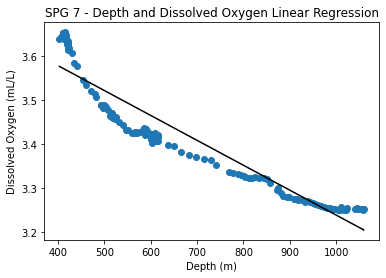

In [99]:
#Plot with annotation of model equation for 39.
fig, ax = plt.subplots()
ax.scatter(Hab39['DEPTH'], Hab39['COND'])
ax.plot(Hab39['DEPTH'], slope*Hab39['DEPTH']+intercept, color = 'black')
ax.set_xlabel('Depth (m)')
ax.set_ylabel('Dissolved Oxygen (mL/L)')
ax.set_title('SPG 7 - Depth and Dissolved Oxygen Linear Regression')
fig.savefig('SPG7 Regression.png')